In [32]:
from datetime import datetime
from scipy.optimize import linprog
from scipy import optimize

import sys
sys.path.append(r'c:\users\severusbot\appdata\local\programs\python\python39\lib\site-packages')
#sys.path.append(r'c:\users\severusbot\appdata\local\programs\python\python3.8\lib\site-packages')

import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

import os
os.path.abspath("")


'C:\\Users\\severusbot\\Quant\\AMS 516'

## $\color{red}{\text{Get Data}}$

We will use python's Yahoo Finance package to get historical stock data. Following the paper's methods,
we will look at daily return data from 01/01/2001 - 04/01/2014.

In [41]:
# OLD DATA

# We will use the 13 week T bill as the risk free rate
rf = 0.0178
'''
prices = pd.DataFrame()

# For now, we are tracking these 5 positions
positions = ['VZ', 'AAPL', 'T', 'AMD', 'JPM', 'BAC', 'ABBV', 'XOM', 'PM']
startDate = datetime(2018, 1, 1)
endDate = datetime(2019, 1, 1)

for ticker in positions:
    temp = yf.Ticker(ticker).history(start = startDate, end = endDate)[['Close']]
    temp.rename(columns = {'Close': str(ticker)}, inplace = True)
    prices = pd.concat([prices, temp], axis = 1)

# Convert to percent change
returns = prices.pct_change(1).iloc[1:, :]
returns = returns.dropna()

frac=0.75
cutoff = np.floor(frac*len(returns.index)).astype(int)

returns_train = returns.iloc[:cutoff]
returns_test = returns.iloc[cutoff:]
TrainDays = len(returns_train)
TestDays = len(returns_test)


returns_train.mean()

'''

prices = pd.read_csv('equity_data_2019.csv')
prices['Date'] = pd.to_datetime(prices['Date'], infer_datetime_format = True)
prices.set_index('Date', inplace = True)
prices = prices.dropna()
prices = prices.astype(int)

returns = prices.pct_change().iloc[1:, :] * 100
#returns = returns.fillna(0)
returns = returns.iloc[1:253, :10]
frac=0.75
cutoff = np.floor(frac*len(returns.index)).astype(int)

returns_train = returns.iloc[:cutoff]
returns_test = returns.iloc[cutoff:]
TrainDays = len(returns_train)
TestDays = len(returns_test)


'''
equity_data=pd.read_csv('equity_data_2019.csv')
equity_data.index=equity_data['Date']
equity_data=equity_data.drop(columns=['Date'])

returns=((equity_data/equity_data.shift(1))-1)
returns=returns.fillna(0)
returns=returns.iloc[1:, :5]
frac=0.75
cutoff=np.floor(frac*len(returns.index)).astype(int)

returns_train = returns.iloc[:cutoff]
returns_test = returns.iloc[cutoff:]

returns = returns.iloc[:, :]

positions = list(returns.columns)
returns
'''

"\nequity_data=pd.read_csv('equity_data_2019.csv')\nequity_data.index=equity_data['Date']\nequity_data=equity_data.drop(columns=['Date'])\n\nreturns=((equity_data/equity_data.shift(1))-1)\nreturns=returns.fillna(0)\nreturns=returns.iloc[1:, :5]\nfrac=0.75\ncutoff=np.floor(frac*len(returns.index)).astype(int)\n\nreturns_train = returns.iloc[:cutoff]\nreturns_test = returns.iloc[cutoff:]\n\nreturns = returns.iloc[:, :]\n\npositions = list(returns.columns)\nreturns\n"

In [56]:
returns.mean().mean()

0.07536587023879267

In [42]:
returns

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP
Date,,,,,,,,,,
2019-05-29,-1.226994,-4.651163,0.000000,0.000000,-3.345725,-0.561798,0.000000,0.000000,-1.798561,-1.242236
2019-05-30,-0.621118,0.000000,1.333333,-1.282051,2.307692,0.564972,0.000000,0.000000,0.366300,0.628931
2019-05-31,-0.625000,-2.439024,0.000000,-1.298701,-1.879699,0.000000,0.000000,0.000000,-1.459854,0.000000
2019-06-03,0.628931,2.500000,-1.315789,-1.315789,0.000000,-1.685393,-2.325581,0.000000,-4.074074,-2.500000
2019-06-04,2.500000,4.878049,2.666667,1.333333,2.298851,1.142857,2.380952,2.631579,3.474903,1.923077
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-1.123596,0.000000,0.000000,-1.111111,1.176471,0.476190,0.000000,0.000000,0.304878,-0.588235
2019-12-26,0.000000,0.000000,0.000000,0.000000,-0.581395,0.473934,0.000000,0.000000,0.607903,0.591716
2019-12-27,0.568182,0.000000,0.000000,0.000000,-1.169591,0.000000,1.724138,0.000000,-0.302115,0.000000


Text(0, 0.5, 'Daily Returns')

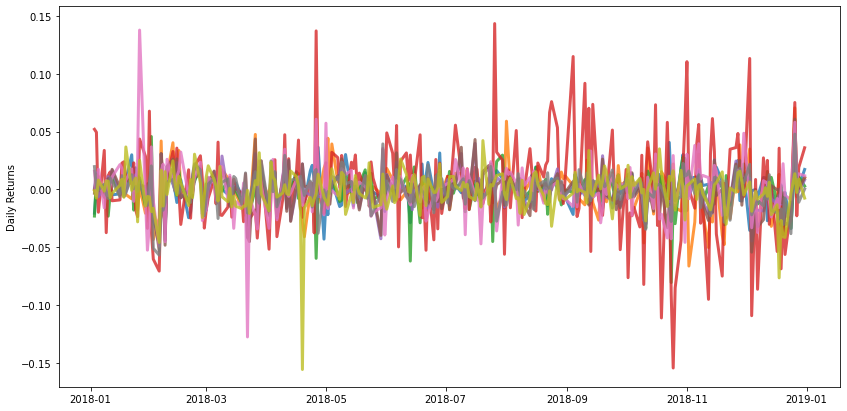

In [72]:
plt.figure(figsize = (14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw = 3, alpha = 0.8, label = c)

plt.ylabel('Daily Returns')

## $\color{red}{\text{Perform Reguralization on the Covariance Matrix}}$

We want to make sure our covariance matrix is nonsingular. Let's use regularization on the covariance matrix and the James Stein estimator for the mean vector.

The regularized covariance matrix is shown as 
$\hat{\Gamma} = \rho_1 \Gamma_S + \rho_2 I$

and the estimated mean
$\hat{\mu} = (1 - \rho)\mu_S + \rho \eta 1$

In [60]:
def regularization(matrix, days):
    
    cov = matrix.cov()

    # Compute sample covariance matrix
    sampleCov = np.dot(matrix.values.T, matrix.values) / len(matrix.columns)
    sampleMean = matrix.mean()
    
    I = np.identity(len(cov.columns))
    
    # Compute the estimates
    mu = np.dot(cov, I)
    alpha = np.linalg.norm(cov - mu * I)
    beta = np.linalg.norm(sampleCov - cov)
    delta = np.linalg.norm(sampleCov - mu * I)

    row1 = (beta**2)/(alpha**2 + beta**2)
    row2 = (alpha**2)/(delta**2)
    
    covEstimate = row1 * mu * I + row2 * sampleCov  
    
    # Find the mean estimate
    eta = max(sampleMean.sum() / sampleMean.size, 0.0004)   
    denom = np.dot(np.transpose((sampleMean - eta*np.ones(shape = (len(sampleMean),))).values.reshape((len(sampleMean), 1))),
                   np.dot(np.linalg.pinv(covEstimate), (sampleMean - eta*np.ones(shape = (len(sampleMean),))).values.reshape((len(sampleMean), 1))))
    '''
    denom = np.dot(np.dot(np.transpose((sampleMean - eta*np.ones(shape = (len(sampleMean),))).values.reshape((len(sampleMean), 1))), days),
                   np.dot(np.linalg.pinv(covEstimate), (sampleMean - eta*np.ones(shape = (len(sampleMean),))).values.reshape((len(sampleMean), 1))))
    '''
    
    rightside = ((len(sampleMean) - 2) / days) / (denom + len(sampleMean) + 2)
    leftside = 1
    rho = min(leftside, rightside)[0][0]       
    meanEstimate = (1 - rho)*sampleMean + rho*eta*np.ones(shape = (len(sampleMean),))
    
    return covEstimate, meanEstimate



In [66]:
'''
lamba = 0.5
N = len(returns_train.columns)
sampleCov = returns_train.cov()
estCov = sampleCov * (TrainDays - 1) / (TrainDays - N - 2)
ones = np.ones(shape = (1, len(returns_train.cov())))
left_side = estCov * (1 + 1/(TrainDays + lamba))
right_side = (lamba / (TrainDays * (TrainDays + 1 + lamba))) * ((ones * np.transpose(ones)) / (np.dot(ones, np.linalg.pinv(estCov)) * ones))

reg_Cov = left_side + right_side
'''

## $\color{red}{\text{Compute the Minimum Variance Portfolio}}$

Following Markowitz's ideas, we can compute the minimum variance portfolio for a given expected return and risk adversion level.

We want to constrain the portfolio to long only, so we need to a quadratic programming approach.

In [44]:
def minimum_var(matrix, include_Shrinkage = False, portfolios = 50000):
    
    rf = .0178
    
    if include_Shrinkage == True:
        meanVector = matrix[0]
        covMatrix = matrix[1]
    
    else:
        meanVector = matrix.mean()
        covMatrix = matrix.cov()    
    
    port_weights = []
    port_returns = []
    port_volatility = []
    port_sharpe = []
    
    for port in range(portfolios):
        weights = np.random.random(len(meanVector))
        
        # Need to normalize
        weights = weights / np.sum(weights)
        port_weights.append(weights)
        
        # Annualized throughout the period
        returns = np.dot(weights, meanVector) * len(matrix)
        port_returns.append(returns)
        
        # Compute the variance of the portfolio
        variance = len(matrix) * covMatrix.mul(weights, axis = 0).mul(weights, axis = 1).sum().sum()
        ann_sd = np.sqrt(variance)
        port_volatility.append(ann_sd)
        
        # Compute the Sharpe Ratio of the portfolio
        sharpe = (returns - rf) / ann_sd
        port_sharpe.append(sharpe)
        
        #returns = np.sum(mean_returns * weights) * len(sample)
        #std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(len(matrix))

    results = {'Returns': port_returns, 'Volatility': port_volatility, 'Sharpe Ratio': port_sharpe}
        
    for c,s in enumerate(covMatrix.columns.tolist()):
        results[s + ' weight'] = [w[c] for w in port_weights]
    
    df = pd.DataFrame(results)
    
    return df
        

In [6]:
results = minimum_var(returns_train)

# Return the minimum variance portfolio
minPort = results.iloc[results['Volatility'].idxmin()]
maxSharpe = results.iloc[results['Sharpe Ratio'].idxmax()]
minPort, maxSharpe

KeyboardInterrupt: 

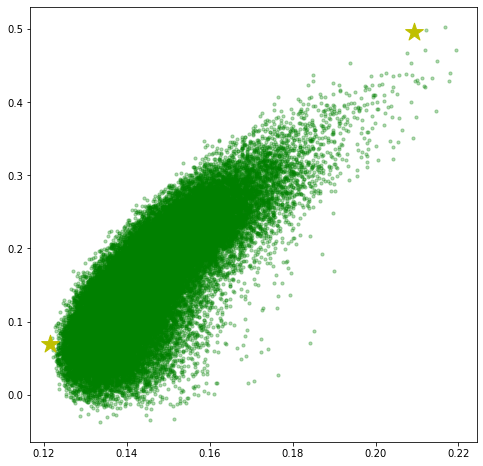

In [77]:
plt.subplots(figsize = (8, 8))
plt.scatter(results['Volatility'], results['Returns'], marker = 'o', s = 10, alpha = 0.3, color = 'green')
plt.scatter(minPort[1], minPort[0], color = 'y', marker = '*', s = 350)
plt.scatter(maxSharpe[1], maxSharpe[0], color = 'y', marker = '*', s = 350)

In [59]:
print(prices.resample('Y').last().pct_change().mean())

MMM     0.018350
AOS     0.035148
ABT     0.319201
ABBV    0.154414
ABMD    0.310229
          ...   
YUM     0.169357
ZBRA    0.453076
ZBH     0.158234
ZION    0.079264
ZTS     0.363996
Length: 496, dtype: float64


Now let's include the shrinkage estimates of the mean and covariance matrix. We can use the same function, just need to pass the shrinkage flag.

In [74]:
#df = minimum_var([estMean, estCov], True)
estCov, estMean = regularization(returns_train, TrainDays)

data = estCov
estCov = pd.DataFrame(data=data[0:,0:], 
                index=[i for i in range(data.shape[0])], 
                columns=['f'+str(i) for i in range(data.shape[1])])

estCov.columns = returns_train.columns

results_shrink = minimum_var([estMean, estCov], True)
minPort_Shrink = results_shrink.iloc[results_shrink['Volatility'].idxmin()]
maxSharpe_Shrink = results_shrink.iloc[results_shrink['Sharpe Ratio'].idxmax()]
minPort_Shrink, maxSharpe_Shrink

(Returns         0.000852
 Volatility      0.007342
 Sharpe Ratio   -2.308463
 VZ weight       0.154450
 AAPL weight     0.098896
 T weight        0.120148
 AMD weight      0.037683
 JPM weight      0.169932
 BAC weight      0.122415
 ABBV weight     0.059410
 XOM weight      0.144413
 PM weight       0.092654
 Name: 39824, dtype: float64,
 Returns         0.005808
 Volatility      0.020170
 Sharpe Ratio   -0.594553
 VZ weight       0.031956
 AAPL weight     0.232705
 T weight        0.001841
 AMD weight      0.408797
 JPM weight      0.009805
 BAC weight      0.071714
 ABBV weight     0.001264
 XOM weight      0.223483
 PM weight       0.018434
 Name: 27635, dtype: float64)

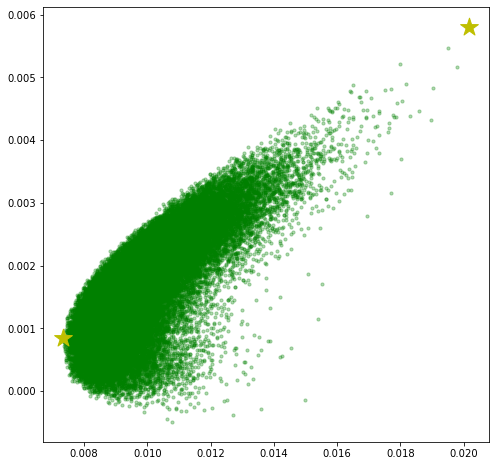

In [75]:
plt.subplots(figsize = (8, 8))
plt.scatter(results_shrink['Volatility'], results_shrink['Returns'], marker = 'o', s = 10, alpha = 0.3, color = 'green')
plt.scatter(minPort_Shrink[1], minPort_Shrink[0], color = 'y', marker = '*', s = 350)
plt.scatter(maxSharpe_Shrink[1], maxSharpe_Shrink[0], color = 'y', marker = '*', s = 350)

## $\color{red}{\text{Out of Sample Testing}}$

We can use the weights of both the original and shrinkage portfolios to analyze the out of sample results.

In [82]:
minPort_Shrink.iloc[3:].to_numpy(), returns_test.mean().to_numpy()

(array([0.15445001, 0.09889562, 0.12014797, 0.03768282, 0.1699323 ,
        0.12241502, 0.05940965, 0.14441302, 0.09265359]),
 array([ 1.09804727e-03, -5.30101140e-03, -2.10724524e-03, -6.64995931e-03,
        -2.06674663e-03, -2.57057871e-03, -6.93480561e-06, -3.20836431e-03,
        -2.77350209e-03]))

In [84]:
# Consider the shrinkage portfolio

ret_shrinkOOS = np.dot(minPort_Shrink.iloc[3:].to_numpy(), returns_test.mean().to_numpy()) * len(returns_test)
std_shrinkOOS = np.sqrt(np.dot(minPort_Shrink.iloc[3:].to_numpy().T, 
                     np.dot(returns_test.cov(), minPort_Shrink.iloc[3:].to_numpy()))) * np.sqrt(len(returns_test))

print(f'OUT OF SAMPLE PERFORMANCE FOR SHRINKAGE PORTFOLIO: {ret_shrinkOOS} (Return), {std_shrinkOOS} (Variance)')

ret_OOS = np.dot(minPort.iloc[3:].to_numpy(), returns_test.mean().to_numpy()) * len(returns_test)
std_OOS = np.sqrt(np.dot(minPort.iloc[3:].to_numpy().T, 
                     np.dot(returns_test.cov(), minPort.iloc[3:].to_numpy()))) * np.sqrt(len(returns_test))

print(f'OUT OF SAMPLE PERFORMANCE FOR REGULAR PORTFOLIO: {ret_OOS} (Return), {std_OOS} (Variance)')

OUT OF SAMPLE PERFORMANCE FOR SHRINKAGE PORTFOLIO: -0.14143656460761758 (Return), 0.10589053283932569 (Variance)
OUT OF SAMPLE PERFORMANCE FOR REGULAR PORTFOLIO: -0.13621132826460303 (Return), 0.10040267591285769 (Variance)


## $\color{red}{\text{Finding the Maximum Return Portfolio}}$

If we want to use Markowitz's ideas, we need to first establish an expected return. We can define this a lot of different ways, but will chose to let it represent the maximum possible return of the portfolio.

The objective function is:
$\max \biggr(\sum_{i = 1}^{N}W_i \mu_i \biggr)$
$\\$ subject to
$\sum_{i = 1}^{N} W_i = 1$ and $0 \leq W_i \leq 1$

In [45]:
def MaxRetPort(mean):
    
    c = (np.multiply(-1, mean))
    A = np.ones([len(mean), 1]).T
    b = [1]
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0, 0.33), method = 'simplex') 
    
    return res

In [64]:
estCov, estMean = regularization(returns_train, TrainDays)
maxPort = MaxRetPort(returns_train.mean())
weights = maxPort.x
maxExpectedReturn = np.dot(weights, returns_train.mean())
print(f'Maximum Expected Portfolio Period Return: {np.round(maxExpectedReturn, 5)}')

Maximum Expected Portfolio Period Return: 0.16969


<ipython-input-45-a465f410095b>:6: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0, 0.33), method = 'simplex')


## $\color{red}{\text{Finding the Maximum Return Portfolio}}$

With the maximum expected return known, we now need to find the minimum expected return. These results will serve as constraints on our mean-variance optimization search.

The objective function is:
$\min \biggr(\sqrt{\sum_{i} \sum_{j} W_i W_j \sigma_{ij}} \biggr)$
$\\$ subject to
$\sum_{i = 1}^{N} W_i = 1$ and $0 \leq W_i \leq 1$

In [47]:
def MinVarPort(cov, meanVector = None, R = None, flag = True):
    
    # Objective function
    def f(weights, cov):
        return np.dot(np.dot(weights, cov), weights)
    
    # Constraints
    def wConstraint(weights):
        A = np.ones(weights.shape)
        b = 1
        val = np.dot(weights, A) - b        
        return val

    def rConstraint(weights, meanVector, R):
        A = np.array(meanVector)
        b = R
        val = np.dot(weights, A) - b
        return val
    
    # Initialize weights and constraints
    weights = np.repeat(1, len(cov))
    
    # Assume we don't want a single position larger than 33%
    bnds = tuple([(0, 0.33) for _ in weights])
    if (flag == True):
        cons = ({'type': 'eq', 'fun' : wConstraint})
        opt = optimize.minimize (f, x0 = weights, args = (cov),  
                                 bounds = bnds, constraints = cons, tol = 10**-3)
        
    else:
        cons = ({'type': 'eq', 'fun': wConstraint}, {'type': 'ineq', 'fun': rConstraint, 'args': (meanVector, R)})
        opt = optimize.minimize (f, args = (cov), method ='trust-constr', 
                                 x0 = weights, bounds = bnds, constraints = cons, tol = 10**-3)
    
    return opt

In [67]:
minPort = MinVarPort(estCov)
minVarWeights = minPort.x
minExpectedReturn = np.dot(minVarWeights, returns_train.mean())
print(f'Minimum Expected Portfolio Period Return: {np.round(minExpectedReturn, 5)}')


Minimum Expected Portfolio Period Return: 0.0699


With our upper and lower bounds, we need to define a constrained minimum variance function that will be used in the mean-variance optimization.

In [52]:
def MeanVarPort(bnds, matrix):

    increment = 0.0001
    lower = bnds[0]
    upper = bnds[1]

    meanVector = matrix.mean()
    covMatrix = matrix.cov()
    
    xOptimal = []
    minRiskPoint = []
    expPortfolioReturnPoint = []

    while (lower < upper):

        result3 = MinVarPort(covMatrix, meanVector, lower, False)
        xOptimal.append(result3.x)
        expPortfolioReturnPoint.append(lower)
        lower = lower + increment
   
    xOptimalArray = np.array(xOptimal)
    minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray, covMatrix)), np.transpose(xOptimalArray)))
    riskPoint =   np.sqrt(minRiskPoint*251) 
    retPoint = 251*np.array(expPortfolioReturnPoint) 
    
    return riskPoint, retPoint

Size of the  efficient set: (945, 10)
Optimal weights of the efficient set portfolios: 
 [[ 0.07597898  0.16708735  0.15448665 ...  0.08965263  0.02337847
   0.15028405]
 [ 0.07598159  0.16717964  0.15447757 ...  0.0896894   0.02341711
   0.15011708]
 [ 0.07598425  0.16727349  0.15446803 ...  0.08972714  0.02345678
   0.149948  ]
 ...
 [-0.00054502  0.33014289  0.08550852 ...  0.25730934 -0.00037025
  -0.00060132]
 [-0.00060845  0.33017876  0.08579643 ...  0.25736276 -0.00042885
  -0.00066424]
 [-0.00066795  0.3302141   0.08609175 ...  0.25740628 -0.00048833
  -0.00072758]]
Annualized Risk and Return of the efficient set portfolios: 
 [[15.47708488 18.88683146]
 [15.47745588 18.91193146]
 [15.4778337  18.93703146]
 ...
 [19.49501583 42.53103146]
 [19.49627494 42.55613146]
 [19.49746241 42.58123146]]


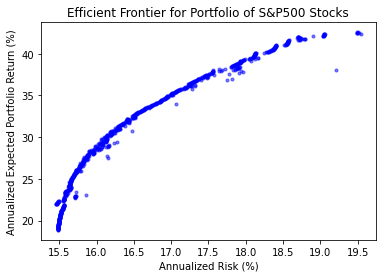

In [57]:
bounds = [minExpectedReturn, maxExpectedReturn]
riskPoint, retPoint = MeanVarPort(bounds, returns_train)

NoPoints = riskPoint.size

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for Portfolio of S&P500 Stocks')
plt.xlabel('Annualized Risk (%)')
plt.ylabel('Annualized Expected Portfolio Return (%)' )
plt.scatter(riskPoint, retPoint, s=area, c=colours, alpha =0.5)
plt.show()